In [1]:
import os.path
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class ResNetBlock(nn.Module): 

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) 
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): 
        return self.model(input)

In [3]:
netG = ResNetGenerator()
model_path = 'data/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [4]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

In [5]:
imgs = []
imgs_out = []

path = "data/hourse"
valid_images = [".jpg", ".png"]


for i in os.listdir(path):
    ext = os.path.splitext(i)[1]
    if ext.lower() not in valid_images:
        continue
    img = Image.open(os.path.join(path, i))
    imgs.append(img)
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_out = netG(batch_t)
    out_t = (batch_out.data.squeeze() + 1.0) / 2.0
    out_img = transforms.ToPILImage()(out_t)
    imgs_out.append(out_img)

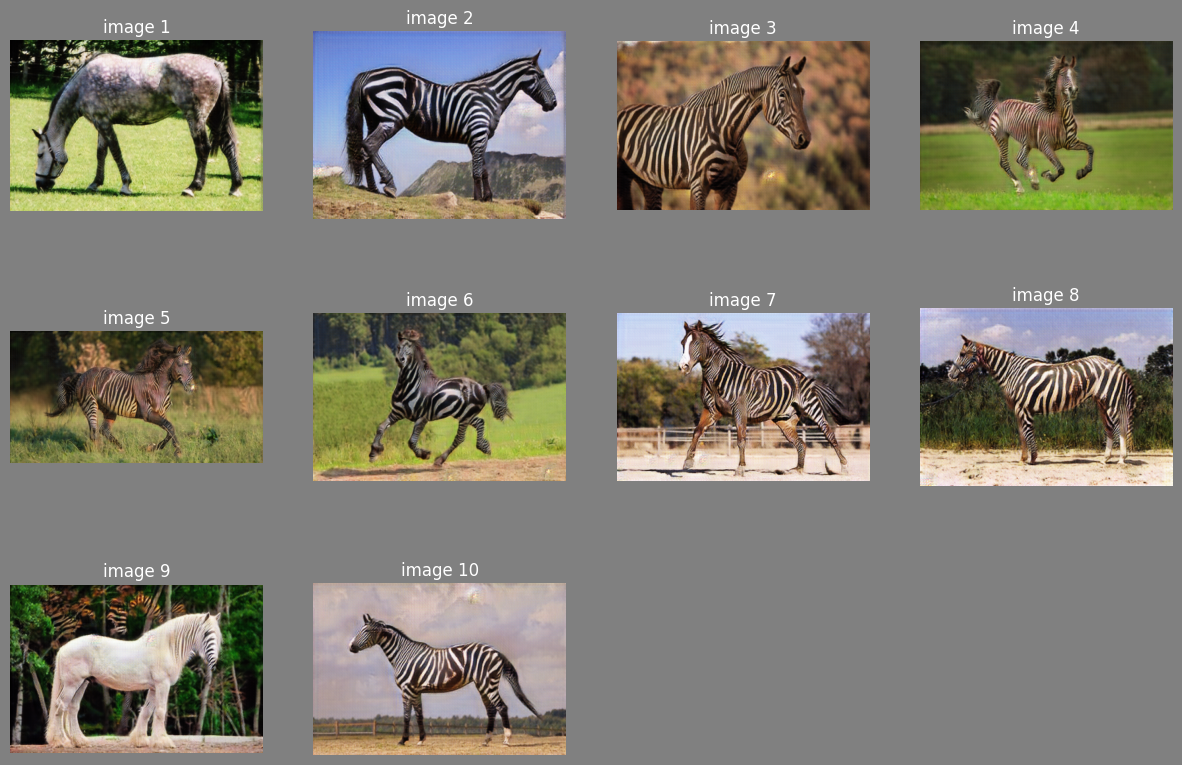

In [6]:
img_number = len(imgs)
columns = math.ceil(np.sqrt(img_number))
if img_number > columns*(columns-1):
    rows = columns
else:
    rows = columns-1

fig = plt.figure(figsize=(15, 10), facecolor='gray')

for i in range(img_number):
    fig.add_subplot(rows, columns, i + 1)
    plt.title("image " + str(i+1), color='white')
    plt.imshow(imgs_out[i])
    plt.axis('off')
plt.show()